# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №1. Image Classification. </center>

В данной лабораторной работе вам предлагается обучить модель на основе нейронной сети для распознавания рукописных букв английского алфавита.

## Данные

Данные представлены двумя датасетами: обучающим (`train`) и тестовым (`test`). Изображения для каждого датасета находятся в `images.zip`.  
  
Обучающая выборка состоит из 65000 изображений - по 2500 изображений для каждой буквы.  
Тестовая выборка состоит из 13000 изображений - по 500 изображений для каждой буквы.  
  
Все изображения - монохромные (но в формате RGB), размерности $28 \times 28$ пикселей, в формате JPEG. 
В названии каждого файла содержатся буква, которая представлена на изображении, и уникальный номер изображения: `a_00002.jpg`.  
  
**NB:** Все изображения представлены в перевернутом виде, для корректного отображения их нужно сначала транспонировать. 

In [1]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

from pathlib import Path
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter

In [2]:
DEVICE_TYPE = "cuda" if torch.cuda.is_available() else "cpu"
#jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    IN_COLAB = False

data_root = '/content/drive/MyDrive/Neural Networks/images/' if IN_COLAB else 'C:\\Users\\samws\\Desktop\\images'

In [4]:
pic = plt.imread(f'{data_root}/train/a/a_00002.jpg')
print(pic.shape)

(28, 28, 3)


In [5]:
pic = np.transpose(pic, axes=(1, 0, 2))

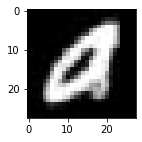

In [6]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

In [7]:
class ImageDataset(torch.utils.data.Dataset): 
    
    def __init__(self, x, y):
        self.x=x
        self.y=y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
           
        return self.x[idx], self.y[idx]

In [17]:
def format_targets(path):
    data=[]
    targets=[]
    
    for root, dirs, _ in os.walk(path):
        for i, dir in enumerate(dirs):
            for file in os.listdir(f"{root}/{dir}"):
                pic = plt.imread(f"{root}/{dir}/{file}")
                pic = torch.tensor(np.transpose(pic, axes=(1, 0, 2)))
                pic = torch.div(pic, 255)   # fix for scalar-byte error
 
                data.append(pic)
                targets.append(i)
    return data, targets

In [18]:
X, y = format_targets(f"{data_root}/train")

In [19]:
X_test, y_test = format_targets(f"{data_root}/test")

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [21]:
dataset_train = ImageDataset(X_train, y_train)
dataset_val = ImageDataset(X_val, y_val)
dataset_test = ImageDataset(X_test, y_test)

In [130]:
class Model():
    def __init__(self, model, mode, datasets, batch_size, criterion, 
                 optimizer, tensorboard=True, device_type=DEVICE_TYPE, 
                 metrics_path="model-results/"):
        self.model = model
        self.mode = mode
        self.criterion = criterion
        self.optimizer = optimizer
        self.metrics_path = metrics_path
        self.shape = np.array([np.array(i) for i in datasets[0][1][0]]).shape
        self.model_name = f"{model.__class__.__name__}--{str(datetime.datetime.now()).replace(' ', '--').replace(':', '-').split('.')[0]}"
        self.device(device_type)
        self.batch_size = batch_size
        self.data_loader(datasets, batch_size)
        
        if tensorboard:
            self.tb = SummaryWriter()

    def device(self, device):
        self.device_type = device
        if device == "cuda":
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            self.model.to(self.device)

    def save_model(self):
        torch.save(self.model.state_dict(), f"{self.metrics_path}parameters/{self.model_name}.pt")

    def data_loader(self, datasets, batch_size):
        if self.device_type=="cuda":
            self.train_dataloader = torch.utils.data.DataLoader(datasets[0], batch_size, shuffle=True)
            self.val_dataloader = torch.utils.data.DataLoader(datasets[1], batch_size)
            self.test_dataloader = torch.utils.data.DataLoader(datasets[2], batch_size)

    def learn(self, epochs):
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}:")
            train_loss, train_acc = self.train()
            val_loss, val_acc = self.validate()
            self.tensorboard([['Training Loss', train_loss, epoch],
                              ['Validation Loss', val_loss, epoch],
                              ['Traning Accuracy', train_acc, epoch],
                              ['Validation Accuracy', val_acc, epoch],
                              ['Learning Rate', self.optimizer.param_groups[0]['lr'], epoch]])
        print("=============================")

    def train(self):
        size = len(self.train_dataloader.dataset)
        self.model.train()

        final_loss = 0
        final_acc = 0
        correct = 0

        for i, (X, y) in enumerate(self.train_dataloader):
            if self.mode == 'NCHW':
                X = X.permute(0, 3, 1, 2)
                    
            X = X.to(self.device_type)
            y = y.to(self.device_type)

            # Calculating loss
            output = self.model(X)
            loss = self.criterion(output, y)

            # Backpropagation
            self.optimizer.zero_grad()   # zero the parameter gradients
            loss.backward()
            self.optimizer.step()

            _, predicted = torch.max(output, 1)
            correct += (predicted == y).sum().item()

            if i % 100 == 0:
                loss, current = loss.item(), i * len(X)
                final_loss = loss
                print(f"[TRAIN] [{current:>5d}/{size:>5d}] Loss: {loss:>3f}")

        final_acc = (correct / size) * 100
            
        return final_loss, final_acc

    def validate(self, log=True):
        size = len(self.val_dataloader.dataset)
        num_batches = len(self.val_dataloader)
        self.model.eval()
        loss, correct = 0, 0

        with torch.no_grad():
            for X, y in self.val_dataloader:
                if self.mode == 'NCHW':
                    X = X.permute(0, 3, 1, 2)
                    
                X = X.to(self.device_type)
                y = y.to(self.device_type)

                # Calculating loss
                output = self.model(X)
                loss += self.criterion(output, y).item()

                _, predicted = torch.max(output, 1)
                correct += (predicted == y).sum().item()
        loss /= num_batches
        correct /= size
        acc = 100 * correct

        print(f"[VALIDATION] Stats:\nAccuracy: {acc:>0.1f}%\nAverage loss: {loss:>6f}\n")
        return loss, acc

    def get_accuracy(self):
        size = len(self.test_dataloader.dataset)
        correct = 0
        total = 0
        predictions = []
        
        with torch.no_grad():
            for X, y in self.test_dataloader:
                if self.mode == 'NCHW':
                    X = X.permute(0, 3, 1, 2)

                X = X.to(self.device_type)
                y = y.to(self.device_type)

                output = self.model(X)
                _, predicted = torch.max(output, 1)
                predictions.extend(predicted)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        self.predictions = list(map(lambda x : x.item(), predictions))         
        print(f'Accuracy of {self.model_name} on {size} test images: {(correct / total) * 100}%')

    def get_predictions(self):
        if not self.predictions:
            self.get_accuracy()
        return self.predictions

    def tensorboard(self, *scalars):
        for name, scalar, epoch in scalars[0]:
            self.tb.add_scalar(name, scalar, epoch)

**Задание 1**

*Модель с 2 полносвязными слоями:*

In [22]:
class NN_2d(nn.Module):
    def __init__(self):
        super(NN_2d, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28 * 3, 256),
            nn.SiLU(),
            nn.Linear(256, 26)
        )

    def forward(self, x):
        x = self.layers(self.flatten(x))
        return x

In [23]:
nn_2d_model = NN_2d()
nn_2d = Model(model=nn_2d_model, mode='NHWC', 
              datasets=[dataset_train, dataset_val, dataset_test],
              batch_size=32, criterion=nn.CrossEntropyLoss(), 
              optimizer=optim.SGD(nn_2d_model.parameters(), lr=0.001, momentum=0.9))

In [27]:
nn_2d.learn(10)

Epoch 1:
[TRAIN] [    0/45500] Loss: 0.266134
[TRAIN] [ 3200/45500] Loss: 0.123073
[TRAIN] [ 6400/45500] Loss: 0.304276
[TRAIN] [ 9600/45500] Loss: 0.197955
[TRAIN] [12800/45500] Loss: 0.577057
[TRAIN] [16000/45500] Loss: 0.340216
[TRAIN] [19200/45500] Loss: 0.159241
[TRAIN] [22400/45500] Loss: 0.212899
[TRAIN] [25600/45500] Loss: 0.227090
[TRAIN] [28800/45500] Loss: 0.317415
[TRAIN] [32000/45500] Loss: 0.228027
[TRAIN] [35200/45500] Loss: 0.316122
[TRAIN] [38400/45500] Loss: 0.419588
[TRAIN] [41600/45500] Loss: 0.915117
[TRAIN] [44800/45500] Loss: 0.307662
[VALIDATION] Stats:
Accuracy: 87.7%
Average loss: 0.413859

Epoch 2:
[TRAIN] [    0/45500] Loss: 0.299907
[TRAIN] [ 3200/45500] Loss: 0.195421
[TRAIN] [ 6400/45500] Loss: 0.182124
[TRAIN] [ 9600/45500] Loss: 0.161268
[TRAIN] [12800/45500] Loss: 0.186302
[TRAIN] [16000/45500] Loss: 0.152354
[TRAIN] [19200/45500] Loss: 0.437240
[TRAIN] [22400/45500] Loss: 0.101931
[TRAIN] [25600/45500] Loss: 0.262077
[TRAIN] [28800/45500] Loss: 0.2996

In [28]:
nn_2d.get_accuracy()

Accuracy of NN_2d--2021-12-01--13-47-00 on 13000 test images: 88.12307692307692%


*Модель с 3 полносвязными слоями:*

In [ ]:
class NN_3d(nn.Module):
    def __init__(self):
        super(NN_3d, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28 * 3, 592),
            nn.ReLU(),
            nn.Linear(592, 234),
            nn.ReLU(),
            nn.Linear(234, 26),
        )

    def forward(self, x):
        x = self.layers(self.flatten(x))
        return x

In [ ]:
nn_3d_model = NN_3d()
nn_3d = Model(model=nn_3d_model, mode='NHWC', 
              datasets=[dataset_train, dataset_val, dataset_test],
              batch_size=32, criterion=nn.CrossEntropyLoss(), 
              optimizer=optim.SGD(nn_3d_model.parameters(), lr=0.001, momentum=0.9))

In [ ]:
nn_3d.learn(10)

Epoch 1:
[TRAIN] [    0/45500] Loss: 0.303332
[TRAIN] [ 3200/45500] Loss: 0.630325
[TRAIN] [ 6400/45500] Loss: 0.565267
[TRAIN] [ 9600/45500] Loss: 0.299317
[TRAIN] [12800/45500] Loss: 0.302177
[TRAIN] [16000/45500] Loss: 0.706550
[TRAIN] [19200/45500] Loss: 0.504027
[TRAIN] [22400/45500] Loss: 0.347147
[TRAIN] [25600/45500] Loss: 0.379582
[TRAIN] [28800/45500] Loss: 0.146537
[TRAIN] [32000/45500] Loss: 0.482343
[TRAIN] [35200/45500] Loss: 0.368772
[TRAIN] [38400/45500] Loss: 0.364569
[TRAIN] [41600/45500] Loss: 0.381982
[TRAIN] [44800/45500] Loss: 0.454079
[VALIDATION] Stats:
Accuracy: 86.5%
Average loss: 0.454427

Epoch 2:
[TRAIN] [    0/45500] Loss: 0.545647
[TRAIN] [ 3200/45500] Loss: 0.506898
[TRAIN] [ 6400/45500] Loss: 0.561669
[TRAIN] [ 9600/45500] Loss: 0.458553
[TRAIN] [12800/45500] Loss: 0.167205
[TRAIN] [16000/45500] Loss: 0.443917
[TRAIN] [19200/45500] Loss: 0.911562
[TRAIN] [22400/45500] Loss: 0.450572
[TRAIN] [25600/45500] Loss: 0.173598
[TRAIN] [28800/45500] Loss: 0.3260

In [ ]:
nn_3d.get_accuracy()

Accuracy of NN_3d--2021-11-30--18-30-07 on 13000 test images: 88.27692307692307%


*Confusion matrix для наилучшей модели*

<AxesSubplot:>

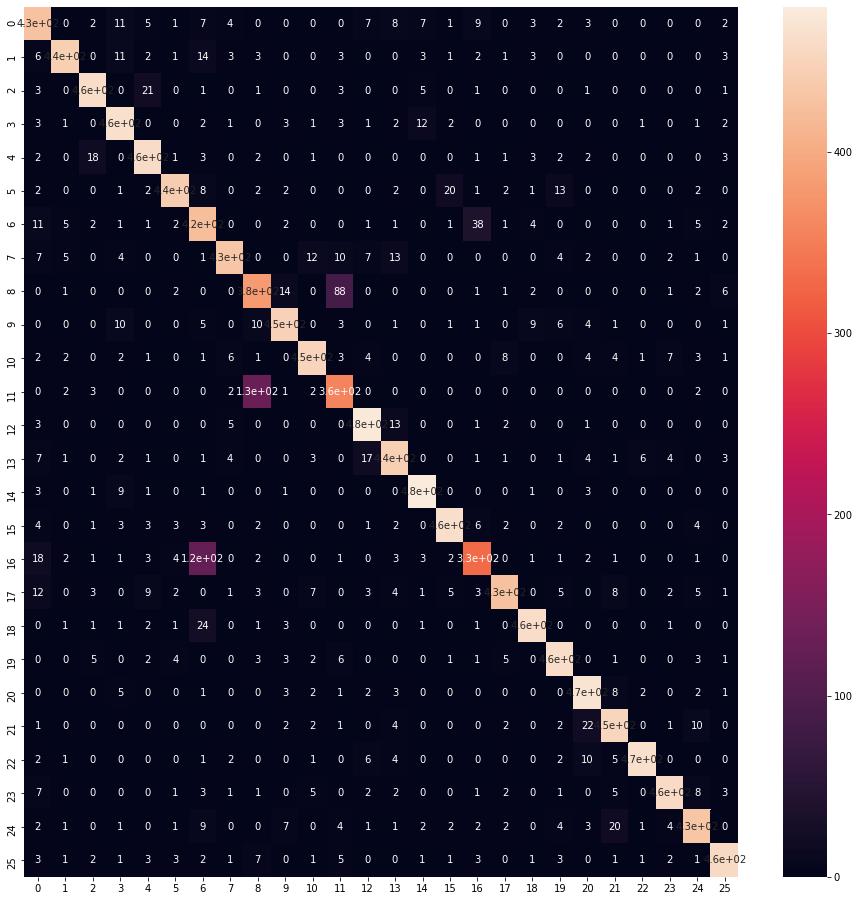

In [ ]:
cf_best = confusion_matrix(y_test, nn_3d.get_predictions())
plt.figure(figsize=(16, 16))
sns.heatmap(cf_best, annot=True)

*Лучшие и худшие буквы по точности детекции*

In [ ]:
letters = [cf_best[i][i] for i in range(26)]
print(f"Best recognized: {chr(np.argmax(letters) + 97)} (accuracy: {max(letters) / (len(dataset_test) / 26)})")    # unicode a = 97
print(f"Worst recognized: {chr(np.argmin(letters) + 97)} (accuracy: {min(letters) / (len(dataset_test) / 26)})")

Best recognized: o (accuracy: 0.96)
Worst recognized: q (accuracy: 0.662)


*10 путающихся пар*

In [ ]:
confusing_letters = []
cf_copy = cf_best.copy()             # copy initial for further operations
np.fill_diagonal(cf_copy, 0)    # remove data for same letters

for i in range(26):
    for j in range(26):
        if len(confusing_letters) < 10:
            confusing_letters.append((cf_copy[i][j], chr(i+97), chr(j+97)))
        elif min(confusing_letters)[0] < cf_copy[i][j]:
            confusing_letters = sorted(confusing_letters)
            confusing_letters[0] = (cf_copy[i][j], chr(i+97), chr(j+97))
    confusing_letters = sorted(confusing_letters, reverse=True)

for id, (num, correct, wrong) in enumerate(confusing_letters):
    print(f"{id + 1}. Letter [{correct}] was recognized as [{wrong}] {num} times")

1. Letter [l] was recognized as [i] 131 times
2. Letter [q] was recognized as [g] 123 times
3. Letter [i] was recognized as [l] 88 times
4. Letter [g] was recognized as [q] 38 times
5. Letter [s] was recognized as [g] 24 times
6. Letter [v] was recognized as [u] 22 times
7. Letter [c] was recognized as [e] 21 times
8. Letter [y] was recognized as [v] 20 times
9. Letter [f] was recognized as [p] 20 times
10. Letter [q] was recognized as [a] 18 times


*Точность распознавания первой буквы фамилии: S*

In [ ]:
s_index = 18
s_confusion = sorted([(conf, id) for id, conf in enumerate(cf_copy[s_index])], 
                     reverse=True)

print(f"Letter [s] accuracy: {cf_best[s_index][s_index] / (len(dataset_test) / 26)}")
for num, i in s_confusion[:5]:
    print(f"Letter [s] was recognized as [{chr(i + ord('a'))}] {num} times")

Letter [s] accuracy: 0.926
Letter [s] was recognized as [g] 24 times
Letter [s] was recognized as [j] 3 times
Letter [s] was recognized as [e] 2 times
Letter [s] was recognized as [x] 1 times
Letter [s] was recognized as [q] 1 times


**Задание 2**

In [29]:
def test_conv_pool(c, train, convs=None, pool=None):
    X, y = next(iter(train))    # we need only one batch
    X = X.permute(0, 3, 1, 2)
    print(X.shape)
    for conv in convs:
        X = conv(X)
        print(X.shape)
        X = pool(X)
        print(X.shape)
        print("-------------")

In [ ]:
class ConvNN_1(nn.Module):
    def __init__(self):
        super(ConvNN_1, self).__init__()
        self.flatten = nn.Flatten()     # transform to vector
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(864, 128),
            nn.ReLU(),
            nn.Linear(128, 26)
        )

    def forward(self, x):
        x = self.flatten(self.conv_layers(x))
        return self.linear_layers(x)

In [ ]:
conv_nn_1_model = ConvNN_1()
conv_nn_1 = Model(model=conv_nn_1_model, mode='NCHW', 
              datasets=[dataset_train, dataset_val, dataset_test],
              batch_size=32, criterion=nn.CrossEntropyLoss(), 
              optimizer=optim.SGD(conv_nn_1_model.parameters(), 
                                  lr=0.001, momentum=0.9))

In [ ]:
test_conv_pool(c=conv_nn_1.model, train=conv_nn_1.train_dataloader, convs=[nn.Conv2d(3, 6, 5)], pool=nn.MaxPool2d(2, 2))

torch.Size([32, 3, 28, 28])
torch.Size([32, 6, 24, 24])
torch.Size([32, 6, 12, 12])
-------------


In [ ]:
conv_nn_1.learn(10)

Epoch 1:
[TRAIN] [    0/45500] Loss: 0.132850
[TRAIN] [ 3200/45500] Loss: 0.284760
[TRAIN] [ 6400/45500] Loss: 0.245676
[TRAIN] [ 9600/45500] Loss: 0.275561
[TRAIN] [12800/45500] Loss: 0.376189
[TRAIN] [16000/45500] Loss: 0.367443
[TRAIN] [19200/45500] Loss: 0.262529
[TRAIN] [22400/45500] Loss: 0.584393
[TRAIN] [25600/45500] Loss: 0.343989
[TRAIN] [28800/45500] Loss: 0.195929
[TRAIN] [32000/45500] Loss: 0.221621
[TRAIN] [35200/45500] Loss: 0.396057
[TRAIN] [38400/45500] Loss: 0.357875
[TRAIN] [41600/45500] Loss: 0.316390
[TRAIN] [44800/45500] Loss: 0.573092
[VALIDATION] Stats:
Accuracy: 88.5%
Average loss: 0.368495

Epoch 2:
[TRAIN] [    0/45500] Loss: 0.122057
[TRAIN] [ 3200/45500] Loss: 0.272015
[TRAIN] [ 6400/45500] Loss: 0.311238
[TRAIN] [ 9600/45500] Loss: 0.213178
[TRAIN] [12800/45500] Loss: 0.114041
[TRAIN] [16000/45500] Loss: 0.081329
[TRAIN] [19200/45500] Loss: 0.213338
[TRAIN] [22400/45500] Loss: 0.355670
[TRAIN] [25600/45500] Loss: 0.240296
[TRAIN] [28800/45500] Loss: 0.2970

In [ ]:
class ConvNN_2(nn.Module):
    def __init__(self):
        super(ConvNN_2, self).__init__()
        self.flatten = nn.Flatten()     # transform to vector
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 26),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(self.conv_layers(x))
        return self.linear_layers(x)

In [ ]:
conv_nn_2_model = ConvNN_2()
conv_nn_2 = Model(model=conv_nn_2_model, mode='NCHW', 
              datasets=[dataset_train, dataset_val, dataset_test],
              batch_size=32, criterion=nn.CrossEntropyLoss(), 
              optimizer=optim.SGD(conv_nn_2_model.parameters(), 
                                  lr=0.001, momentum=0.9))

In [ ]:
test_conv_pool(c=conv_nn_2.model, train=conv_nn_2.train_dataloader, convs=[nn.Conv2d(3, 6, 5), nn.Conv2d(6, 16, 5)], pool=nn.MaxPool2d(2, 2))

torch.Size([32, 3, 28, 28])
torch.Size([32, 6, 24, 24])
torch.Size([32, 6, 12, 12])
-------------
torch.Size([32, 16, 8, 8])
torch.Size([32, 16, 4, 4])
-------------


In [ ]:
conv_nn_2.learn(10)

Epoch 1:
[TRAIN] [    0/45500] Loss: 0.477710
[TRAIN] [ 3200/45500] Loss: 0.508106
[TRAIN] [ 6400/45500] Loss: 0.093222
[TRAIN] [ 9600/45500] Loss: 0.473658
[TRAIN] [12800/45500] Loss: 0.279387
[TRAIN] [16000/45500] Loss: 0.183284
[TRAIN] [19200/45500] Loss: 0.537440
[TRAIN] [22400/45500] Loss: 0.437723
[TRAIN] [25600/45500] Loss: 0.820323
[TRAIN] [28800/45500] Loss: 0.506973
[TRAIN] [32000/45500] Loss: 0.524420
[TRAIN] [35200/45500] Loss: 0.494051
[TRAIN] [38400/45500] Loss: 0.568672
[TRAIN] [41600/45500] Loss: 0.330914
[TRAIN] [44800/45500] Loss: 0.550424
[VALIDATION] Stats:
Accuracy: 85.9%
Average loss: 0.446525

Epoch 2:
[TRAIN] [    0/45500] Loss: 0.090504
[TRAIN] [ 3200/45500] Loss: 0.240767
[TRAIN] [ 6400/45500] Loss: 0.298699
[TRAIN] [ 9600/45500] Loss: 0.511385
[TRAIN] [12800/45500] Loss: 0.074744
[TRAIN] [16000/45500] Loss: 0.578540
[TRAIN] [19200/45500] Loss: 0.474147
[TRAIN] [22400/45500] Loss: 0.106203
[TRAIN] [25600/45500] Loss: 0.277656
[TRAIN] [28800/45500] Loss: 0.1238

In [47]:
class ConvNN_3(nn.Module):
    def __init__(self):
        super(ConvNN_3, self).__init__()
        self.flatten = nn.Flatten()     # transform to vector
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, 5, padding=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1, stride=2),
            nn.ReLU(),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 26),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(self.conv_layers(x))
        return self.linear_layers(x)

In [48]:
conv_nn_3_model = ConvNN_3()
conv_nn_3 = Model(model=conv_nn_3_model, mode='NCHW', 
              datasets=[dataset_train, dataset_val, dataset_test],
              batch_size=32, criterion=nn.CrossEntropyLoss(), 
              optimizer=optim.SGD(conv_nn_3_model.parameters(), 
                                  lr=0.01, momentum=0.9))

In [49]:
test_conv_pool(c=conv_nn_3.model, train=conv_nn_3.train_dataloader, convs=[nn.Conv2d(3, 8, 5), nn.Conv2d(8, 16, 3), nn.Conv2d(16, 32, 3)], pool=nn.MaxPool2d(2, 2))

torch.Size([32, 3, 28, 28])
torch.Size([32, 8, 24, 24])
torch.Size([32, 8, 12, 12])
-------------
torch.Size([32, 16, 10, 10])
torch.Size([32, 16, 5, 5])
-------------
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 1, 1])
-------------


In [52]:
conv_nn_3.learn(10)

Epoch 1:
[TRAIN] [    0/45500] Loss: 0.211746
[TRAIN] [ 3200/45500] Loss: 0.052579
[TRAIN] [ 6400/45500] Loss: 0.063869
[TRAIN] [ 9600/45500] Loss: 0.075095
[TRAIN] [12800/45500] Loss: 0.044974
[TRAIN] [16000/45500] Loss: 0.090066
[TRAIN] [19200/45500] Loss: 0.054790
[TRAIN] [22400/45500] Loss: 0.048354
[TRAIN] [25600/45500] Loss: 0.065129
[TRAIN] [28800/45500] Loss: 0.370632
[TRAIN] [32000/45500] Loss: 0.115969
[TRAIN] [35200/45500] Loss: 0.014122
[TRAIN] [38400/45500] Loss: 0.054312
[TRAIN] [41600/45500] Loss: 0.027773
[TRAIN] [44800/45500] Loss: 0.061659
[VALIDATION] Stats:
Accuracy: 92.4%
Average loss: 0.282891

Epoch 2:
[TRAIN] [    0/45500] Loss: 0.073335
[TRAIN] [ 3200/45500] Loss: 0.041843
[TRAIN] [ 6400/45500] Loss: 0.022359
[TRAIN] [ 9600/45500] Loss: 0.043078
[TRAIN] [12800/45500] Loss: 0.058491
[TRAIN] [16000/45500] Loss: 0.164501
[TRAIN] [19200/45500] Loss: 0.019968
[TRAIN] [22400/45500] Loss: 0.026694
[TRAIN] [25600/45500] Loss: 0.123107
[TRAIN] [28800/45500] Loss: 0.0386

KeyboardInterrupt: ignored

In [ ]:
print("[Models accuracy]")
for model in [conv_nn_1, conv_nn_2, conv_nn_3]:
    model.get_accuracy()

[Models accuracy]
Accuracy of ConvNN_1--2021-12-01--00-09-38 on 13000 test images: 89.9%
Accuracy of ConvNN_2--2021-12-01--00-19-38 on 13000 test images: 90.00769230769231%
Accuracy of ConvNN_3--2021-12-01--00-35-44 on 13000 test images: 92.23846153846154%


*Эксперименты с BatchNorm*

In [30]:
class ConvNN_3_BN(nn.Module):
    def __init__(self):
        super(ConvNN_3_BN, self).__init__()
        self.flatten = nn.Flatten()     # transform to vector
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, 5, padding=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1, stride=2),
            nn.ReLU(),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 26),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(self.conv_layers(x))
        return self.linear_layers(x)

In [32]:
conv_nn_3_bn_model = ConvNN_3_BN()
conv_nn_3_bn = Model(model=conv_nn_3_bn_model, mode='NCHW', 
              datasets=[dataset_train, dataset_val, dataset_test],
              batch_size=32, criterion=nn.CrossEntropyLoss(), 
              optimizer=optim.SGD(conv_nn_3_bn_model.parameters(), 
                                  lr=0.01, momentum=0.9))

In [33]:
test_conv_pool(c=conv_nn_3_bn.model, train=conv_nn_3_bn.train_dataloader, convs=[nn.Conv2d(3, 8, 5), nn.Conv2d(8, 16, 3), nn.Conv2d(16, 32, 3)], pool=nn.MaxPool2d(2, 2))

torch.Size([32, 3, 28, 28])
torch.Size([32, 8, 24, 24])
torch.Size([32, 8, 12, 12])
-------------
torch.Size([32, 16, 10, 10])
torch.Size([32, 16, 5, 5])
-------------
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 1, 1])
-------------


In [36]:
conv_nn_3_bn.learn(10)

Epoch 1:
[TRAIN] [    0/45500] Loss: 0.326752
[TRAIN] [ 3200/45500] Loss: 0.115081
[TRAIN] [ 6400/45500] Loss: 0.231536
[TRAIN] [ 9600/45500] Loss: 0.204611
[TRAIN] [12800/45500] Loss: 0.584011
[TRAIN] [16000/45500] Loss: 0.115385
[TRAIN] [19200/45500] Loss: 0.151749
[TRAIN] [22400/45500] Loss: 0.219834
[TRAIN] [25600/45500] Loss: 0.529908
[TRAIN] [28800/45500] Loss: 0.109642
[TRAIN] [32000/45500] Loss: 0.300212
[TRAIN] [35200/45500] Loss: 0.349228
[TRAIN] [38400/45500] Loss: 0.410096
[TRAIN] [41600/45500] Loss: 0.275862
[TRAIN] [44800/45500] Loss: 0.122532
[VALIDATION] Stats:
Accuracy: 88.5%
Average loss: 0.468818

Epoch 2:
[TRAIN] [    0/45500] Loss: 0.222463
[TRAIN] [ 3200/45500] Loss: 0.189145
[TRAIN] [ 6400/45500] Loss: 0.207860
[TRAIN] [ 9600/45500] Loss: 0.056816
[TRAIN] [12800/45500] Loss: 0.170444
[TRAIN] [16000/45500] Loss: 0.121043
[TRAIN] [19200/45500] Loss: 0.008654
[TRAIN] [22400/45500] Loss: 0.341993
[TRAIN] [25600/45500] Loss: 0.282211
[TRAIN] [28800/45500] Loss: 0.2097

*Эксперименты с GroupNorm*

In [41]:
class ConvNN_3_GN(nn.Module):
    def __init__(self):
        super(ConvNN_3_GN, self).__init__()
        self.flatten = nn.Flatten()     # transform to vector
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, 5, padding=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1, stride=2),
            nn.GroupNorm(4, 16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1, stride=2),
            nn.ReLU(),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 26),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(self.conv_layers(x))
        return self.linear_layers(x)

In [42]:
conv_nn_3_gn_model = ConvNN_3_BN()
conv_nn_3_gn = Model(model=conv_nn_3_gn_model, mode='NCHW', 
              datasets=[dataset_train, dataset_val, dataset_test],
              batch_size=32, criterion=nn.CrossEntropyLoss(), 
              optimizer=optim.SGD(conv_nn_3_gn_model.parameters(), 
                                  lr=0.01, momentum=0.9))

In [43]:
test_conv_pool(c=conv_nn_3_gn.model, train=conv_nn_3_gn.train_dataloader, convs=[nn.Conv2d(3, 8, 5), nn.Conv2d(8, 16, 3), nn.Conv2d(16, 32, 3)], pool=nn.MaxPool2d(2, 2))

torch.Size([32, 3, 28, 28])
torch.Size([32, 8, 24, 24])
torch.Size([32, 8, 12, 12])
-------------
torch.Size([32, 16, 10, 10])
torch.Size([32, 16, 5, 5])
-------------
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 1, 1])
-------------


In [44]:
conv_nn_3_gn.learn(10)

Epoch 1:
[TRAIN] [    0/45500] Loss: 3.260340
[TRAIN] [ 3200/45500] Loss: 3.229055
[TRAIN] [ 6400/45500] Loss: 2.473343
[TRAIN] [ 9600/45500] Loss: 1.414227
[TRAIN] [12800/45500] Loss: 0.980164
[TRAIN] [16000/45500] Loss: 1.269112
[TRAIN] [19200/45500] Loss: 0.983441
[TRAIN] [22400/45500] Loss: 0.720474
[TRAIN] [25600/45500] Loss: 0.866404
[TRAIN] [28800/45500] Loss: 0.782983
[TRAIN] [32000/45500] Loss: 0.848399
[TRAIN] [35200/45500] Loss: 0.503399
[TRAIN] [38400/45500] Loss: 0.773314
[TRAIN] [41600/45500] Loss: 0.900863
[TRAIN] [44800/45500] Loss: 0.556263
[VALIDATION] Stats:
Accuracy: 78.7%
Average loss: 0.693576

Epoch 2:
[TRAIN] [    0/45500] Loss: 0.640231
[TRAIN] [ 3200/45500] Loss: 0.365056
[TRAIN] [ 6400/45500] Loss: 0.483092
[TRAIN] [ 9600/45500] Loss: 0.611410
[TRAIN] [12800/45500] Loss: 0.445342
[TRAIN] [16000/45500] Loss: 0.264954
[TRAIN] [19200/45500] Loss: 0.519983
[TRAIN] [22400/45500] Loss: 0.569014
[TRAIN] [25600/45500] Loss: 0.357949
[TRAIN] [28800/45500] Loss: 0.3228

In [109]:
conv_nn_3_gn.tb

**Бонусные задания**

*Задание 2. Transfer learning: AlexNet*

In [74]:
squeezenet1_0_model = models.squeezenet1_0()

In [75]:
squeezenet1_0 = Model(model=squeezenet1_0_model, mode='NCHW', 
              datasets=[dataset_train, dataset_val, dataset_test],
              batch_size=32, criterion=nn.CrossEntropyLoss(), 
              optimizer=optim.SGD(squeezenet1_0_model.parameters(), 
                                  lr=0.001, momentum=0.9))

In [81]:
squeezenet1_0.learn(10)

Epoch 1:
[TRAIN] [    0/45500] Loss: 0.150624
[TRAIN] [ 3200/45500] Loss: 0.242464
[TRAIN] [ 6400/45500] Loss: 0.076268
[TRAIN] [ 9600/45500] Loss: 0.048410
[TRAIN] [12800/45500] Loss: 0.093472
[TRAIN] [16000/45500] Loss: 0.187770
[TRAIN] [19200/45500] Loss: 0.084868
[TRAIN] [22400/45500] Loss: 0.107517
[TRAIN] [25600/45500] Loss: 0.094064
[TRAIN] [28800/45500] Loss: 0.255458
[TRAIN] [32000/45500] Loss: 0.124050
[TRAIN] [35200/45500] Loss: 0.133561
[TRAIN] [38400/45500] Loss: 0.155471
[TRAIN] [41600/45500] Loss: 0.224445
[TRAIN] [44800/45500] Loss: 0.554901
[VALIDATION] Stats:
Accuracy: 92.3%
Average loss: 0.246158



SqueezeNet показала результаты не более 93%

In [94]:
mobilenet_v2_model = models.mobilenet_v2()

In [95]:
mobilenet_v2 = Model(model=mobilenet_v2_model, mode='NCHW', 
              datasets=[dataset_train, dataset_val, dataset_test],
              batch_size=32, criterion=nn.CrossEntropyLoss(), 
              optimizer=optim.SGD(mobilenet_v2_model.parameters(), 
                                  lr=0.001, momentum=0.9))

In [96]:
mobilenet_v2.learn(10)

Epoch 1:
[TRAIN] [    0/45500] Loss: 6.929721
[TRAIN] [ 3200/45500] Loss: 3.391506
[TRAIN] [ 6400/45500] Loss: 2.965456
[TRAIN] [ 9600/45500] Loss: 2.042739
[TRAIN] [12800/45500] Loss: 1.680615
[TRAIN] [16000/45500] Loss: 1.579372
[TRAIN] [19200/45500] Loss: 1.286599
[TRAIN] [22400/45500] Loss: 1.041623
[TRAIN] [25600/45500] Loss: 1.016049
[TRAIN] [28800/45500] Loss: 0.941437
[TRAIN] [32000/45500] Loss: 1.233910
[TRAIN] [35200/45500] Loss: 1.148206
[TRAIN] [38400/45500] Loss: 0.930782
[TRAIN] [41600/45500] Loss: 0.650535
[TRAIN] [44800/45500] Loss: 0.515959
[VALIDATION] Stats:
Accuracy: 81.9%
Average loss: 0.589884

Epoch 2:
[TRAIN] [    0/45500] Loss: 0.818603
[TRAIN] [ 3200/45500] Loss: 0.530778
[TRAIN] [ 6400/45500] Loss: 0.386296
[TRAIN] [ 9600/45500] Loss: 0.463665
[TRAIN] [12800/45500] Loss: 0.619936
[TRAIN] [16000/45500] Loss: 0.655366
[TRAIN] [19200/45500] Loss: 0.587561
[TRAIN] [22400/45500] Loss: 0.486682
[TRAIN] [25600/45500] Loss: 0.410641
[TRAIN] [28800/45500] Loss: 0.8133

*Tensorboard*

In [125]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [128]:
test_tb = mobilenet_v2.tb

In [129]:
%tensorboard --logdir boards --host=127.0.0.1

Reusing TensorBoard on port 6006 (pid 6736), started 0:08:01 ago. (Use '!kill 6736' to kill it.)

## Основные задания

Ваша задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

### Задание 1  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
При моделировании необходимо попробовать разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д. Оцените качество моделей с различными параметрами, проведите сравнительный анализ. 
2. Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.  
Насколько равномерно обучилась ваша модель? Приведите буквы с самой лучшей и с самой худшей точностью детекции.
3. Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.
4. Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву?     

### Задание 2  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Попробуйте различные значения параметров сверток и числа фильтров на каждом слое. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.  
2. Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.    

### Задание 3    
  
Обучите модель с точностью (accuracy) на тестовых данных:  
- `>= 0.85`    +1 балл
- `>= 0.95`    +2 балла
- `>= 0.99`    +3 балла  

## Бонусные задания

**Задание 1 (1 балл).**  

Напишите на листке белой бумаги (маркером или ручкой) от 5 разных букв (можно больше 5 букв в целом с повторениями, но должно быть минимум 5 разных) английского алфавита (в датасете есть как прописные, так и строчные буквы). Сфотографируйте букву и приведите её картинку к размеру $28\times28$ и, желательно, к чёрно-белой палитре цветов. Передайте получившиеся изображения вашей модели и выполните предсказание, оцените результат.  
  
**Tips:**  
- В датасете все буквы занимают практически всё пространство картинки по высоте или ширине (или вместе). Если ваша буква будет слишком маленькой или большой, это может повлиять на результат детекции.
- Помните, что буква должна быть белого цвета, а фон - чёрного.
- Описание ваших действий при выполнении этого задания (что вы использовали, чтобы привести картинку к нужному виду) категорически приветствуется :)

**Задание 2 (1 балл):**    
  
Используйте transfer learning подход для решения задачи - дообучите какую-либо модель, предобученную на ImageNet, для классификации рукописных букв. Оцените качество решения.  
В качестве предобученой модели можно взять одну из [torchvision models](https://pytorch.org/vision/stable/models.html).

**Задание 3 (1 балл):**  
  
Добавьте вывод значений функции потерь и accuracy в tensorboard.  
Метрики нужно выводить и для обучающей, и для тестовой выборки.